# **LoRA-адаптер для стиля тату "одной линии"**
(сервис генерации уникальных эскизов тату TattiSketch)

# Инструкция для запуска ноутбука

Этот ноутбук выполняет:
- обучение LoRA-адаптера на датасете из 51-го эскиза тату (выполнены в стиле одной непрерывной линии) с использованием платформы Fal.ai;
- генерацию изображений на baseline-модели с использованием платформы Fal.ai;
- генерацию изображений на обученном LoRA-адаптере с использованием платформы Fal.ai;
- расчет, оценку и визуализацию метрик

**Для корректной работы требуется:**
- установить свой API-ключ Fal.ai через `userdata` или переменную `FAL_KEY`;
- загрузить архив `dataset.zip` с датасетом изображений в папку `/content/` для обучения LoRA-адаптера;
- загрузить референс `sample_line.png` в папку `/content/dataset/` для оценки метрик.

---


## 1. Установка зависимостей

In [1]:
!pip install fal-client requests Pillow opencv-python matplotlib scikit-image torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 816.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

## 2. Импорт библиотек и настройка API


In [21]:
import fal_client
import requests
import os
import time
import math
import random
import cv2
import numpy as np
import itertools
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.measure import label
from scipy.spatial.distance import euclidean
import torch
from torchvision import models, transforms
from torchvision.models import VGG19_Weights
from google.colab import userdata
from fal_client import Queued, InProgress, Completed


## Конфигурация


In [3]:
!mkdir -p dataset/refs generated/baseline generated/lora

In [24]:
FAL_KEY = userdata.get('FAL_API_KEY')
os.environ["FAL_KEY"] = FAL_KEY

# Референс
REF_IMAGE_PATH = "/content/dataset/sample_line.png"


## 3. Загрузка датасета на платформу Fal.ai

- загрузить `/content/dataset.zip` - для обучения в Fal.ai
- загрузить референс `/content/dataset/sample_line.png` для оценки метрик

In [ ]:
data_zip_url = fal_client.upload_file("dataset.zip")
print("ZIP загружен:", data_zip_url)

ZIP загружен: https://v3.fal.media/files/penguin/hcFwLHVT-yMDQo6nVq5nr_dataset.zip


## 4. Обучение LoRA-адаптера на платформе Fal.ai


In [ ]:
handler = fal_client.submit(
    "fal-ai/flux-lora-fast-training",
    arguments={
        "images_data_url": data_zip_url,
        "is_style": True,
        "steps": 3000,
        "trigger_word": "single continuous black line drawing, minimalism, no shading, no breaks",
        "create_masks": False
    }
)

while True:
    status = fal_client.status(
        "fal-ai/flux-lora-fast-training",
        handler.request_id,
        with_logs=True
    )

    if isinstance(status, Queued):
        print(f"В очереди (position={status.position})")

    elif isinstance(status, InProgress):
        for log in status.logs or []:
            print(log.get("message", "<no message>"))

    elif isinstance(status, Completed):
        print("Обучение завершено!")
        break

    else:
        raise RuntimeError(f"Unexpected status object: {status!r}")

    time.sleep(30)

result = fal_client.result("fal-ai/flux-lora-fast-training", handler.request_id)
lora_url = result["diffusers_lora_file"]["url"]
print("LoRA weights:", lora_url)

В очереди (position=0)
Archive files: 
[PosixPath('/tmp/tmpo2wx0qo9/47.png'), PosixPath('/tmp/tmpo2wx0qo9/24.png'), PosixPath('/tmp/tmpo2wx0qo9/39.png'), PosixPath('/tmp/tmpo2wx0qo9/12.png'), PosixPath('/tmp/tmpo2wx0qo9/16.png'), PosixPath('/tmp/tmpo2wx0qo9/7.png'), PosixPath('/tmp/tmpo2wx0qo9/40.png'), PosixPath('/tmp/tmpo2wx0qo9/19.png'), PosixPath('/tmp/tmpo2wx0qo9/27.png'), PosixPath('/tmp/tmpo2wx0qo9/1.png'), PosixPath('/tmp/tmpo2wx0qo9/4.png'), PosixPath('/tmp/tmpo2wx0qo9/46.png'), PosixPath('/tmp/tmpo2wx0qo9/13.png'), PosixPath('/tmp/tmpo2wx0qo9/15.png'), PosixPath('/tmp/tmpo2wx0qo9/32.png'), PosixPath('/tmp/tmpo2wx0qo9/42.png'), PosixPath('/tmp/tmpo2wx0qo9/31.png'), PosixPath('/tmp/tmpo2wx0qo9/25.png'), PosixPath('/tmp/tmpo2wx0qo9/48.png'), PosixPath('/tmp/tmpo2wx0qo9/44.png'), PosixPath('/tmp/tmpo2wx0qo9/23.png'), PosixPath('/tmp/tmpo2wx0qo9/30.png'), PosixPath('/tmp/tmpo2wx0qo9/22.png'), PosixPath('/tmp/tmpo2wx0qo9/18.png'), PosixPath('/tmp/tmpo2wx0qo9/3.png'), PosixPath('/tm

Файл весов обученного LoRA-адаптера ("steps": 1000):

In [ ]:
lora_url = "https://v3.fal.media/files/monkey/hL6DMp7b8D-7TET-o8Hk4_pytorch_lora_weights.safetensors"

Файл весов обученного LoRA-адаптера ("steps": 3000):

In [5]:
lora_url = "https://v3.fal.media/files/penguin/O1_RKyPsRx0phG9Dpy65P_pytorch_lora_weights.safetensors"

## 5. Генерация изображений:
- baseline - fal-ai/flux-lora;
- lora - fal-ai/flux-lora + обученный LoRA-адаптер (`lora_url`):
    - для активации весов LoRA-адаптера, обученного на 1000 шагах обновления весов модели, используется триггер: `<single_line_style>`;
    - для активации весов LoRA-адаптера, обученного обученного на 3000 шагах обновления весов модели, используется триггер: `<single continuous black line drawing, minimalism, no shading, no breaks>`

In [6]:
MODEL = "fal-ai/flux-lora"
LORA  = lora_url

# Выбрать в зависимости от параметров обучения
TRIG  = "<single continuous black line drawing, minimalism, no shading, no breaks>"
# TRIG  = "<single_line_style>"

def generate(prompt, use_lora=False):
    seed = random.randint(1, 1_000_000_000)

    # Формируем основной текст промпта
    main_prompt = (
        f"{prompt}, "
        "clean, sharp, and bold outlines optimized for tattoo sketch, "
        "strong contrast and clear readability. "
    )

    args = {
        # Если включаем LoRA — добавляем в prompt триггер
        "prompt": f"{main_prompt} {TRIG}" if use_lora else main_prompt,
        "negative_prompt": (
            "filling, painting, pencil shading, grayscale shading, "
            "color gradients, blurred edges, sketchy lines, gray background, colour background"
        ),
        "image_size": { "width": 512, "height": 512 },
        "num_inference_steps": 44,
        "guidance_scale": 5.5,
        "seed": seed
    }

    if use_lora:
        args["loras"] = [{ "path": LORA, "scale": 0.9 }]

    result = fal_client.run(MODEL, arguments=args)
    url = result["images"][0]["url"]
    return Image.open(requests.get(url, stream=True).raw).convert("RGB")


# Директории для сохранения
os.makedirs("generated/baseline", exist_ok=True)
os.makedirs("generated/lora",     exist_ok=True)

prompts = ["yoga", "book"]

for i, p in enumerate(prompts):
    # Baseline (без LoRA)
    img_base = generate(p, use_lora=False)
    img_base.save(f"generated/baseline/baseline_{i}.png")

    # С LoRA-адаптером
    img_lora = generate(p, use_lora=True)
    img_lora.save(f"generated/lora/lora_{i}.png")


## 6. Метрики качества:

Для количественной оценки ключевых особенностей стиля выполнения эскиза тату "одной линии" выбраны следующие метрики:
1. **Skeleton‑based** метрики:

   – components: число непрерывных частей линии;

   – endpoints: количество концевых точек;

   – branches: число развилок;

   – length: общая длина скелета (в пикселях);

   – tortuosity: отношение длины к прямому расстоянию между концами (если endpoints==2).

2. **Style Loss**:

   – инициализирует VGG-19 с предобученными весами и берёт только сверточные фичи;
   
   – преобразует изображение и эталон в формат, ожидаемый моделью (Resize, ToTensor, Normalize);
   
   – считает Gram-матрицы признаков VGG и возвращает среднеквадратичную разницу между ними, показывая, насколько глубинные паттерны линий сгенерированного изображения отличаются от эталона.

3. **Human Style Score (HSS)**:

   – запрашивает у пользователя субъективную оценку (1–5) для каждого изображения, чтобы учесть человеческое восприятие «правильности» стиля "одной линии".


### 6.1. Оценка Skeleton‑based метрик + визуализация
В данном подходе производится расчет Skeleton‑based метрик для выбранного из датасета референса, получая таким образом «норму» стиля выполнения тату "одной линии"

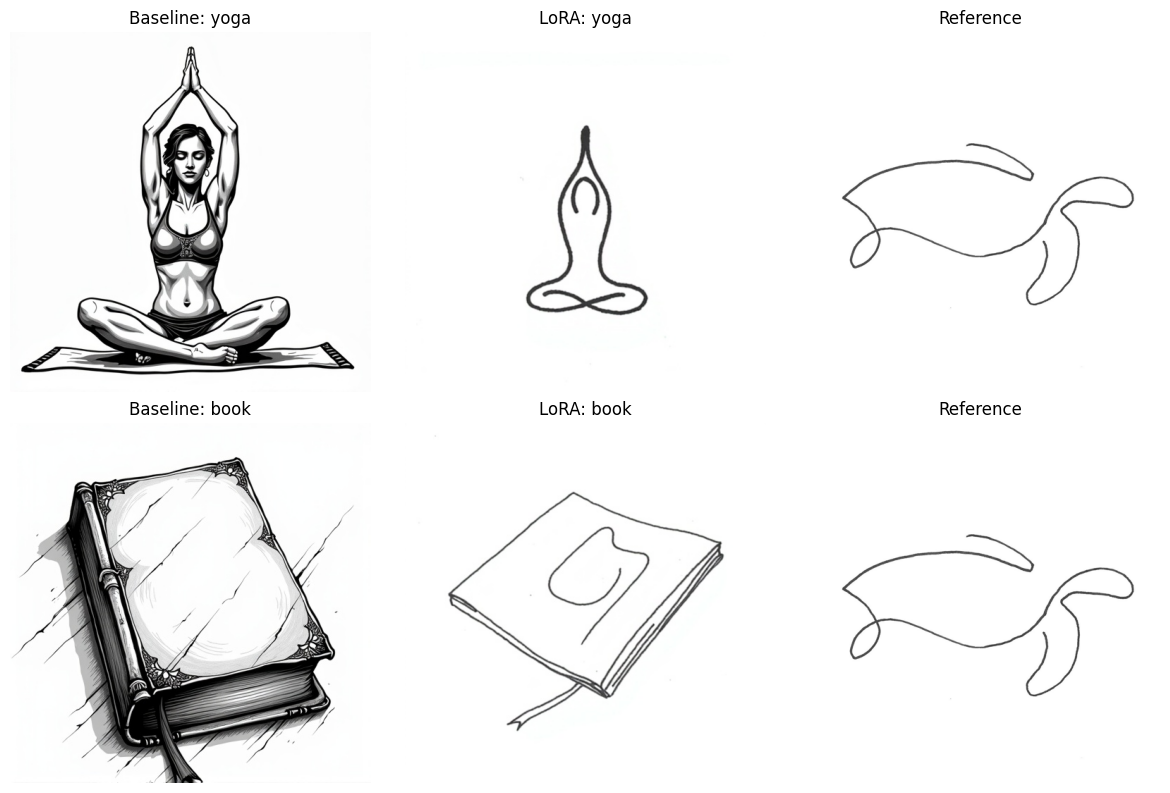

,components,endpoints,branches,length,tortuosity
Baseline,2.0,29.0,352.0,4520.0,NaN
LoRA,2.0,5.0,9.0,894.0,NaN
Reference,1.0,2.0,4.0,1284.0,7.340619


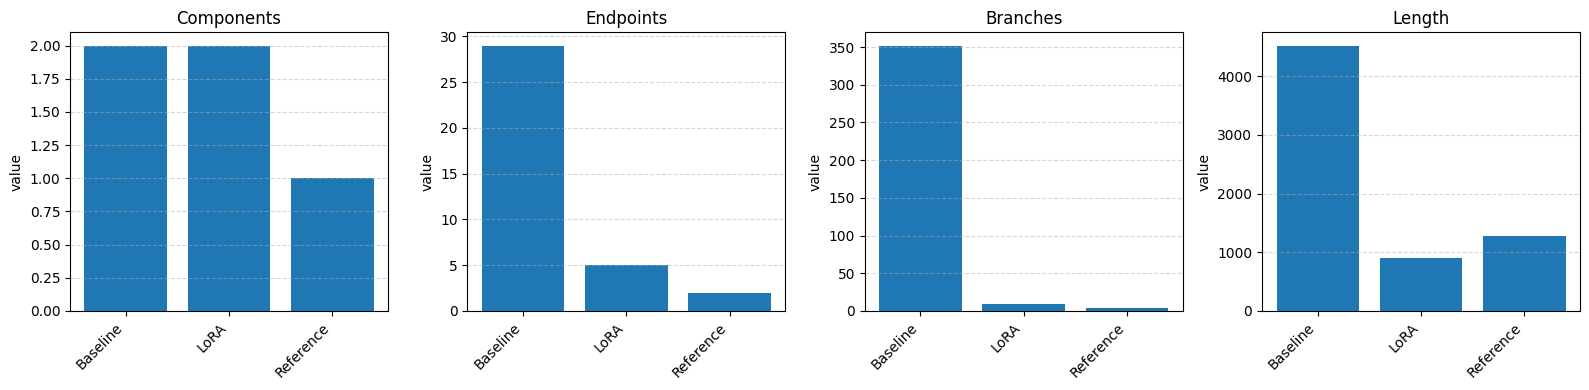

In [27]:
def preprocess(img, thr=200):
    """
    1. Конвертирует RGB-изображение в серое.
    2. Бинаризует (линия → белый фон → чёрное).
    3. Выполняет морфологическое closing, чтобы убрать мелкие разрывы.
    4. Возвращает двоичную маску (0/1) для последующего скелетирования.
    """

    g      = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, bw  = cv2.threshold(g, thr, 255, cv2.THRESH_BINARY_INV)
    bw     = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), 2)
    return bw // 255

def largest_skeleton(mask, min_size=50):
    """
    1. Строит скелет (однопиксельную «ось») из двоичной маски.
    2. Помечает связанные компоненты на скелете.
    3. Оставляет только те компоненты, чьи размеры ≥ min_size (фильтрация артефактов).
    """

    skel = skeletonize(mask.astype(bool)).astype(np.uint8)
    lbl  = label(skel, connectivity=2)
    keep = np.isin(lbl, np.where(np.bincount(lbl.ravel()) >= min_size)[0])
    return (skel * keep).astype(np.uint8)

def neighbours(skel):
    """
    Считает для каждого пикселя скелета число соседей в 8-окрестности.
    Это нужно для детекции концов (1 сосед) и развилок (≥3 соседей).
    """

    return cv2.filter2D(skel, -1, np.array([[1,1,1],[1,0,1],[1,1,1]], np.uint8))

def sk_metrics(img):
    """
    1. Препроцессинг и постобработка скелета (largest_skeleton).
    2. Определяет:
       - components  (число связанных компонент)
       - endpoints   (пиксели с 1 соседом)
       - branches    (пиксели с ≥3 соседями)
       - length      (общая длина скелета, в пикселях)
       - tortuosity  (отношение длины скелета к прямому расстоянию между концами, если концов ровно 2)
    3. Возвращает все метрики в виде словаря.
    """

    skel = largest_skeleton(preprocess(img))
    neigh = neighbours(skel)
    comps = label(skel, connectivity=2).max()
    ep    = int(np.logical_and(skel==1, neigh==1).sum())
    bp    = int(np.logical_and(skel==1, neigh>=3).sum())
    lng   = int(skel.sum())
    tort  = math.nan
    if ep == 2:
        pts = np.column_stack(np.where(np.logical_and(skel==1, neigh==1)))
        tort = lng / euclidean(pts[0], pts[1])
    return dict(components=comps,endpoints=ep,branches=bp,length=lng,tortuosity=tort)

BASELINE_IMG = "/content/generated/baseline/baseline_0.png"
LORA_IMG     = "/content/generated/lora/lora_0.png"

imgs = {"Baseline": BASELINE_IMG, "LoRA": LORA_IMG, "Reference": REF_IMAGE_PATH}

# Вывод сгенерированных и референсного изображений
fig, ax_img = plt.subplots(len(prompts), 3, figsize=(12, 4 * len(prompts)))

for i, p in enumerate(prompts):
    img_b = Image.open(f"generated/baseline/baseline_{i}.png")
    img_l = Image.open(f"generated/lora/lora_{i}.png")
    img_r = Image.open(REF_IMAGE_PATH)

    ax_img[i, 0].imshow(img_b)
    ax_img[i, 0].set_title(f"Baseline: {p}")
    ax_img[i, 0].axis("off")

    ax_img[i, 1].imshow(img_l)
    ax_img[i, 1].set_title(f"LoRA: {p}")
    ax_img[i, 1].axis("off")

    ax_img[i, 2].imshow(img_r)
    ax_img[i, 2].set_title("Reference")
    ax_img[i, 2].axis("off")

plt.tight_layout()
plt.show()

# Расчет метрик и вывод результатов в таблицу
data = {name: sk_metrics(cv2.imread(path)) for name, path in imgs.items()}
df   = pd.DataFrame(data).T
display(df)

# Визуализация bar‑чартами
metrics_to_plot = ["components", "endpoints", "branches", "length"]
n = len(df.index)  # обычно 3: Baseline, LoRA, Reference

fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(4 * len(metrics_to_plot), 4))

for ax, metric in zip(axes, metrics_to_plot):
    ax.bar(df.index, df[metric])
    ax.set_title(metric.capitalize())
    ax.set_ylabel("value")

    ax.set_xticks(range(n))

    ax.set_xticklabels(df.index, rotation=45, ha="right")
    ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()


### 6.2. Оценка метрик Style Loss и HSS + визуализация

Введите HSS (1–5) для каждого изображения:
Baseline — yoga: 1
Baseline — book: 1
LoRA — yoga: 4
LoRA — book: 3


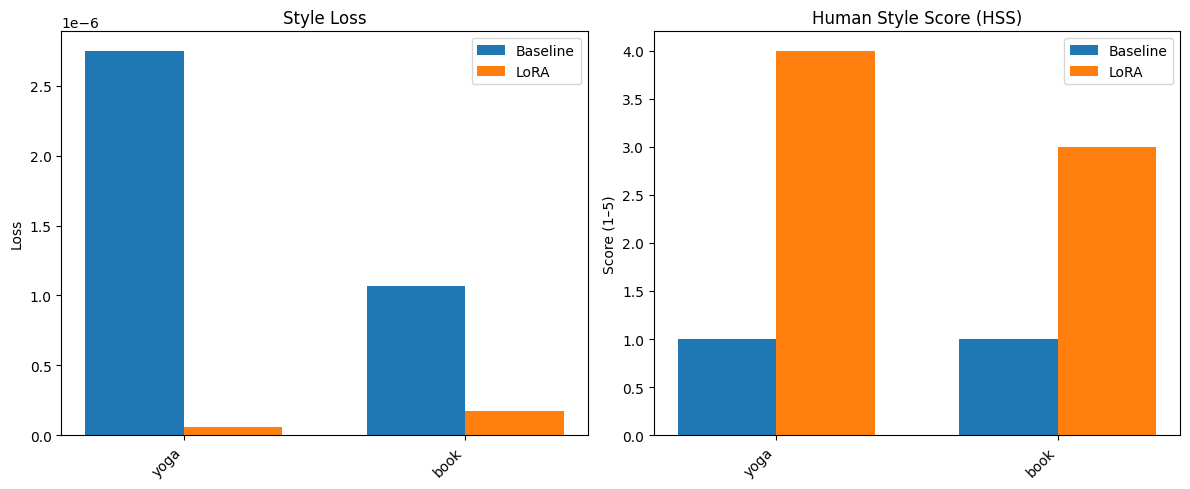

In [26]:
# Инициализируем VGG-19 с актуальными весами и берем только фичи
weights = VGG19_Weights.IMAGENET1K_V1  # или VGG19_Weights.DEFAULT
vgg = models.vgg19(weights=weights).features.eval()

# Штатная предобработка для этих весов
preproc = weights.transforms()

def gram_matrix(x: torch.Tensor) -> torch.Tensor:
    b, d, h, w = x.size()
    f = x.view(b * d, h * w)
    return torch.mm(f, f.t()) / (b * d * h * w)

def style_loss(generated: Image.Image, reference: Image.Image) -> float:
    gen = preproc(generated).unsqueeze(0)  # [1, 3, H, W]
    ref = preproc(reference).unsqueeze(0)
    with torch.no_grad():
        f_gen = vgg(gen)
        f_ref = vgg(ref)
        return torch.mean((gram_matrix(f_gen) - gram_matrix(f_ref)) ** 2).item()

# Счетчики
metrics = {"Baseline": {"StyleLoss": [], "HSS": []},
           "LoRA":     {"StyleLoss": [], "HSS": []}}

# Собираем StyleLoss
for i, prompt in enumerate(prompts):
    img_b = Image.open(f"generated/baseline/baseline_{i}.png").convert("RGB")
    img_l = Image.open(f"generated/lora/lora_{i}.png").convert("RGB")
    metrics["Baseline"]["StyleLoss"].append(style_loss(img_b, REF))
    metrics["LoRA"]["StyleLoss"].append(style_loss(img_l, REF))

# Запрашиваем HSS у пользователя
print("Введите HSS (1–5) для каждого изображения:")
for model in ["Baseline","LoRA"]:
    for i, p in enumerate(prompts):
        val = float(input(f"{model} — {p}: "))
        metrics[model]["HSS"].append(val)

# Визуализация: два bar-чарта в ряд
x    = np.arange(len(prompts))
w    = 0.35
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Style Loss
axes[0].bar(x - w/2, metrics["Baseline"]["StyleLoss"], w, label="Baseline")
axes[0].bar(x + w/2, metrics["LoRA"]["StyleLoss"],     w, label="LoRA")
axes[0].set_xticks(x)
axes[0].set_xticklabels(prompts, rotation=45, ha="right")
axes[0].set_title("Style Loss")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Human Style Score
axes[1].bar(x - w/2, metrics["Baseline"]["HSS"], w, label="Baseline")
axes[1].bar(x + w/2, metrics["LoRA"]["HSS"],     w, label="LoRA")
axes[1].set_xticks(x)
axes[1].set_xticklabels(prompts, rotation=45, ha="right")
axes[1].set_title("Human Style Score (HSS)")
axes[1].set_ylabel("Score (1–5)")
axes[1].legend()

plt.tight_layout()
plt.show()


## 7. Вывод:

### При использовании LoRA-адаптера результаты стали значительно ближе к стилистике техники "одной линии", но пока не стабильны.

**Причина:**
- fal-ai/flux — это базовый text-to-image движок - он не был специально натренирован на следование правилам "одной линии", и полученные веса LoRA-адаптера не позволяют стабильно достигать требуемого результата.

**Предложения по улучшению результата:**
- Увеличить датасет: взять не 51, а, например, 200 референсов, выполненных в стиле тату "одной линии" (без разрывов, шумов, фона, теней, все изображения - одинакового размера черно-белые).

- Тренировать больше шагов: 5000 шагов дадут лучшее закрепление.